In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
import plotly.express as px

/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [21]:
df = gpd.read_file('../raw_data/df_with_bez/merged_bez.shp')
df.dropna(inplace=True)

In [22]:
df = df.rename(
    columns={
        'BEZ': 'Bezirk',
        'child_pov': 'Child poverty',
        'mig_rate': 'Migration rate',
        'unemployme': 'Unemployment',
        'welfare': 'Social benefits',
        'ave_rent': 'Average rent',
        'social_hou': 'Social housing',
        'public_hou': 'Public housing'
    })

In [23]:
df.Bezirk = df.Bezirk.map({
    '01': 'Mitte',
    '02': 'Friedrichshain-Kreuzberg',
    '03': 'Pankow',
    '04': 'Charlottenburg-Wilmersdorf',
    '05': 'Spandau',
    '06': 'Steglitz-Zehlendorf',
    '07': 'Tempelhof-Schöneberg',
    '08': 'Neukölln',
    '09': 'Treptow-Köpenick',
    '10': 'Marzahn-Hellersdorf',
    '11': 'Lichtenberg',
    '12': 'Reinickendorf'
})

<AxesSubplot:>

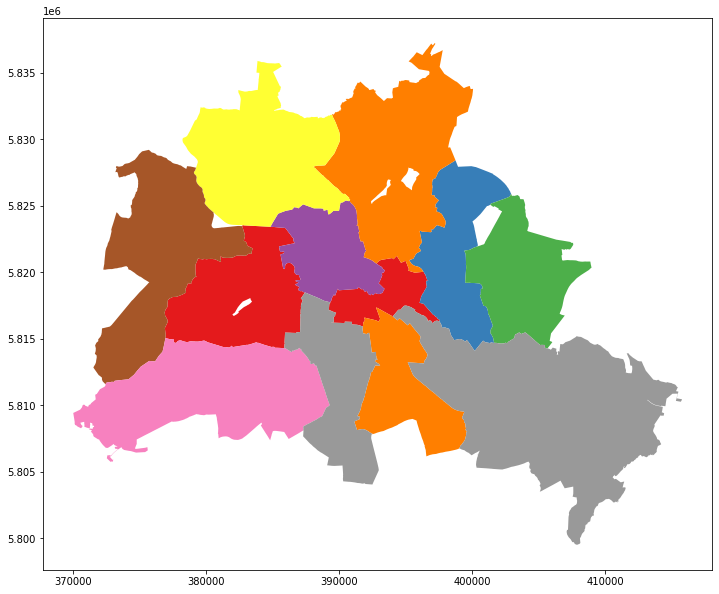

In [58]:
df.dissolve(by='Bezirk', as_index=False).plot(figsize=(12,12), column='Bezirk', cmap='Set1')

<Figure size 432x288 with 0 Axes>

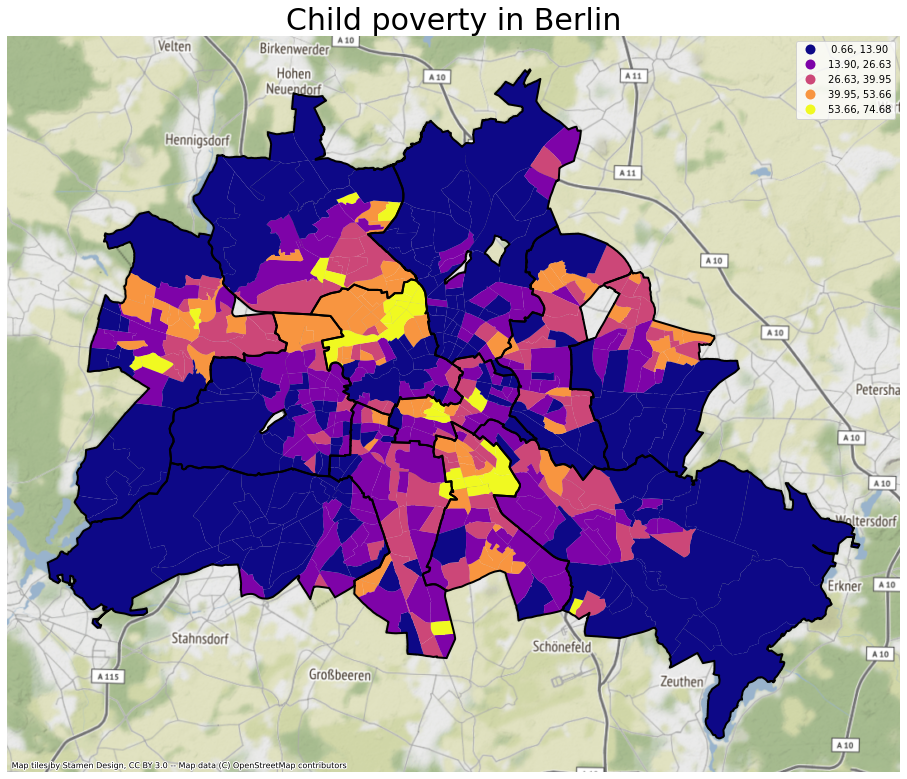

In [69]:
fig = plt.figure()
base = df.dissolve(by='Bezirk', as_index=False).boundary.plot(figsize=(16,16), edgecolor='black', linewidth=2)
ax = df.plot(figsize=(16,16), column='Child poverty', ax=base, cmap='plasma', scheme='NaturalBreaks', legend=True)
ax.set_axis_off()
ax.set_title('Child poverty in Berlin', fontsize=30)
contextily.add_basemap(ax, crs=df.crs)
plt.savefig(fname='plots/child_pov.png',transparent=False, facecolor='white', bbox_inches="tight")

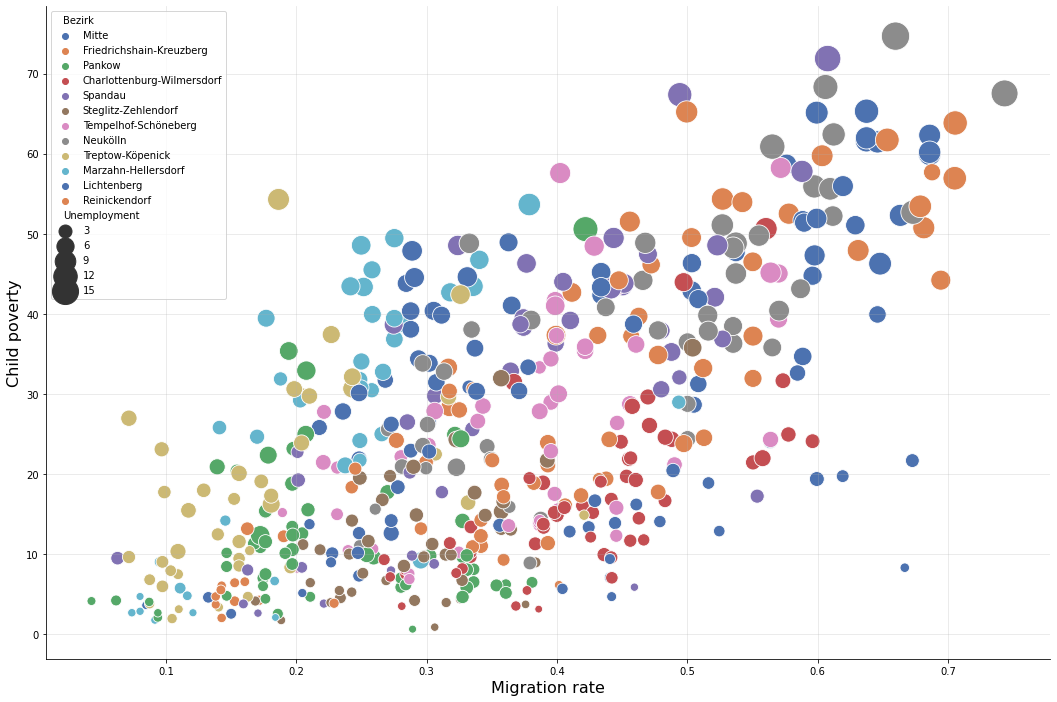

In [71]:
fig = plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x="Migration rate",
                y="Child poverty",
                hue='Bezirk',
                size="Unemployment",
                hue_order=[
                    'Mitte', 'Friedrichshain-Kreuzberg', 'Pankow',
                    'Charlottenburg-Wilmersdorf', 'Spandau',
                    'Steglitz-Zehlendorf', 'Tempelhof-Schöneberg', 'Neukölln',
                    'Treptow-Köpenick', 'Marzahn-Hellersdorf', 'Lichtenberg',
                    'Reinickendorf'
                ],
                palette=sns.color_palette('deep', 12),
                sizes=(60, 800), legend='brief',
                data=df)
ax.grid(alpha=0.3)
ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
ax.set_xlabel('Migration rate', fontsize = 16)
ax.set_ylabel('Child poverty', fontsize = 16)
plt.savefig(fname='plots/scatterplot_mig_rate.png',transparent=False, bbox_inches="tight", facecolor='white')

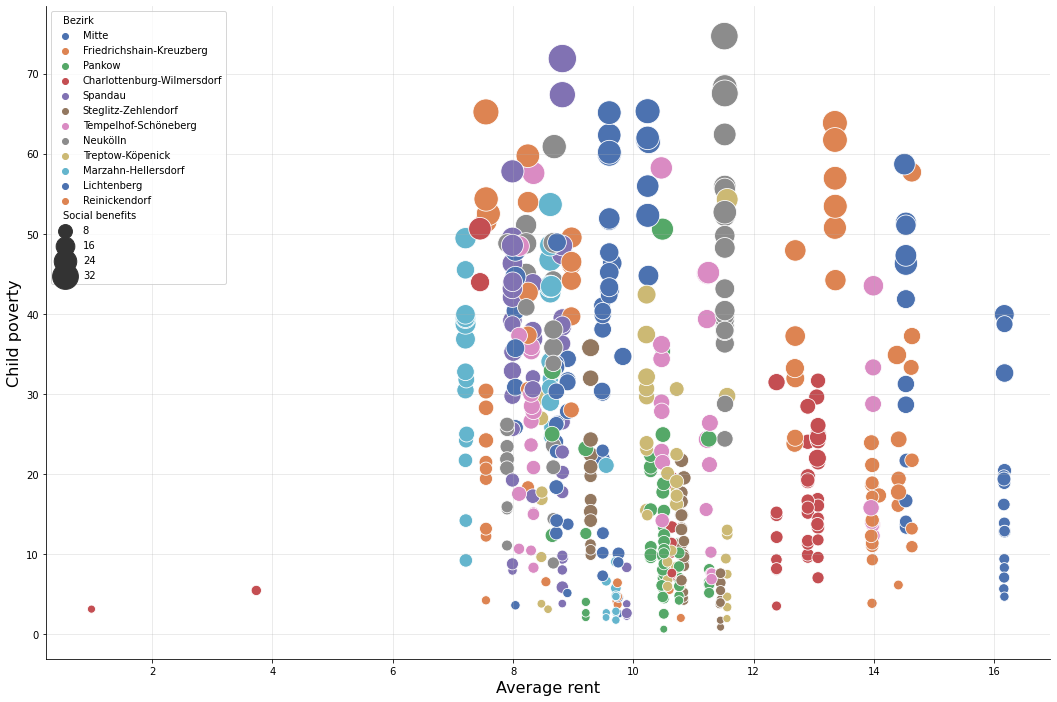

In [7]:
fig = plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x="Average rent",
                y="Child poverty",
                hue='Bezirk',
                size="Social benefits",
                hue_order=[
                    'Mitte', 'Friedrichshain-Kreuzberg', 'Pankow',
                    'Charlottenburg-Wilmersdorf', 'Spandau',
                    'Steglitz-Zehlendorf', 'Tempelhof-Schöneberg', 'Neukölln',
                    'Treptow-Köpenick', 'Marzahn-Hellersdorf', 'Lichtenberg',
                    'Reinickendorf'
                ],
                palette=sns.color_palette('deep', 12),
                sizes=(60, 800), legend='brief',
                data=df)
ax.grid(alpha=0.3)
ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
ax.set_xlabel('Average rent', fontsize = 16)
ax.set_ylabel('Child poverty', fontsize = 16)
plt.savefig(fname='plots/scatterplot_avg_rent.svg',transparent=False)

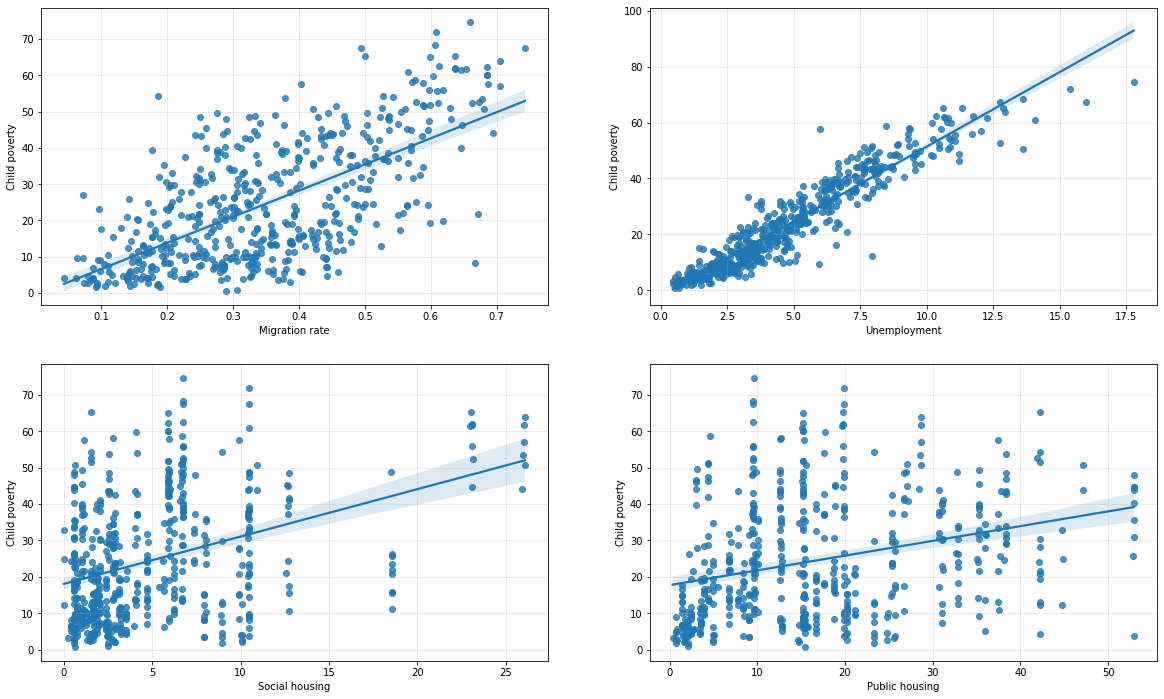

In [37]:
fig=plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.regplot(df['Migration rate'], df['Child poverty'], fit_reg=True)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(2,2,2)
ax2 = sns.regplot(df['Unemployment'], df['Child poverty'], fit_reg=True)
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(2,2,3)
ax3 = sns.regplot(df['Social housing'], df['Child poverty'], fit_reg=True)
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(2,2,4)
ax4 = sns.regplot(df['Public housing'], df['Child poverty'], fit_reg=True)
ax4.grid(alpha=0.3)

plt.savefig(fname='plots/mrate_unempl_social_public.svg',transparent=False)


In [72]:
clustering = gpd.read_file('../raw_data/for_models/cluster_gdf.shp')

In [73]:
from sklearn.preprocessing import robust_scale
clustering['child_pov'] = robust_scale(clustering['child_pov'])

In [74]:
clustering['education'] = robust_scale(clustering['education'])

In [75]:
migration = ['mig_rate', 'child_pov']

In [76]:
infrastructure = [
    'culture', 'stations', 'kita', 'Gymnasium', 'outdoor_fa', 'outdoor_le',
    'vegpm20', 'social_hou', 'public_hou'
]

In [77]:
social_index = ['unemployme', 'welfare']

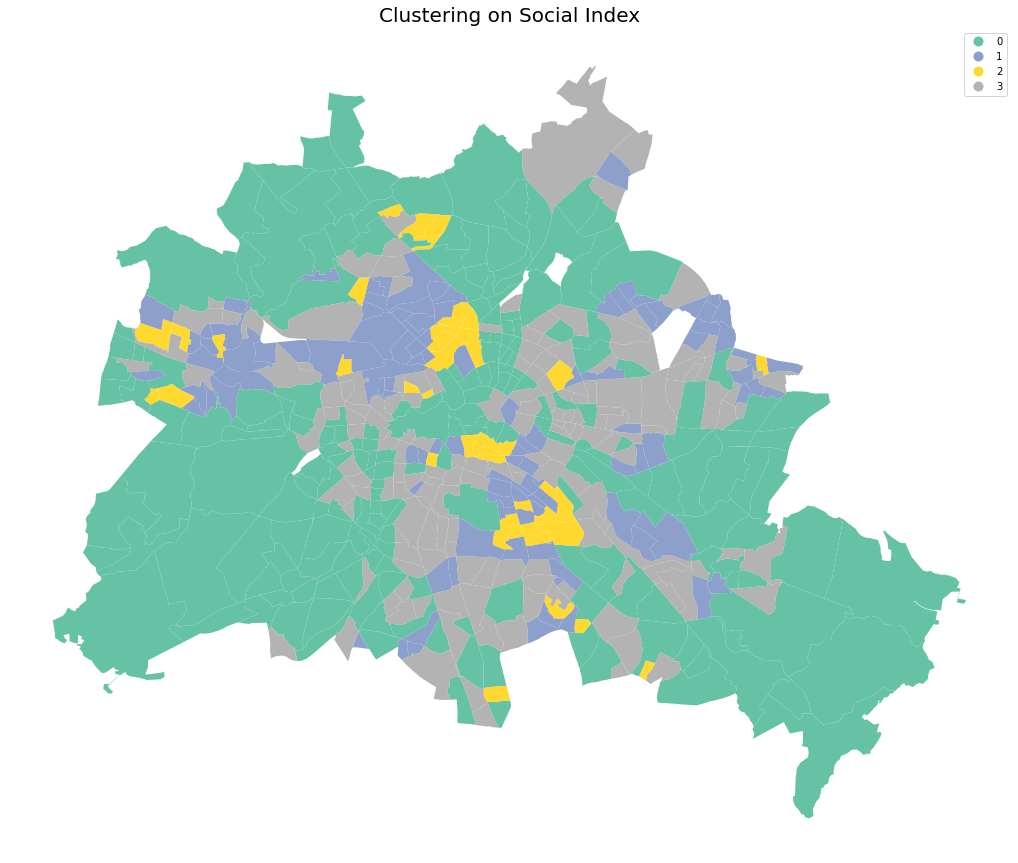

In [117]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(clustering[social_index])
# Assign labels into a column
clustering['label'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(18,18))
clustering.plot(
    column="label", categorical=True, legend=True, linewidth=0, ax=ax, cmap='Set2'
)
# Remove axis
ax.set_axis_off()
ax.set_title("Clustering on Social Index", fontsize=20)
# Display the map
#plt.savefig(fname='plots/cluster_social_index.png',facecolor='white', bbox_inches="tight")
plt.show()

In [115]:
k5means = clustering.groupby("label")[social_index].mean()
k5means.columns = ['Unemployment', 'Social Benefits']
k5means.style.set_properties(**{'background-color': '#17becf'}, subset=['Unemployment'])


,Unemployment,Social Benefits
label,,
0,-0.541270,-0.434813
1,0.815588,0.878146
2,1.795579,1.792573
3,0.130408,0.132101
